<font size=22>**XGBoost models**</font>

In [1]:
#!pip install --upgrade  xgboost
#!pip install --upgrade scikit-learn scikit-optimize
#!pip install --upgrade pip


In [2]:
#!pip show xgboost


Name: xgboost
Version: 2.0.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /Users/Carmen/.pyenv/versions/3.10.6/envs/game-of-thrones-survival/lib/python3.10/site-packages
Requires: numpy, scipy
Required-by: 


# Imports

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Loading Data

In [3]:
df = pd.read_csv('../processed_data/cleaned_data_final.csv')


## Setting X and y

In [4]:
X = df
X = X.drop(columns = ["name",'isAlive','episode','deaths','season',
       'episode_num'], axis=1)
X.columns


Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity'], dtype='object')

In [5]:
y = df[["isAlive"]]
y.head()


,isAlive
0,0
1,0
2,1
3,0
4,1


## Train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Preprocessor

In [7]:
X = df[['male', 'isMarried', 'isNoble', 'popularity', 'origin']]
y = df['isAlive']

no_transformation_features = ['male', 'isMarried', 'isNoble']
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
####
# Impute then scale numerical values:
num_transformer = Pipeline(steps=[
    ('Standard_scaler', StandardScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore',sparse_output=False))

])

# Define column transformer
# Parallelize "num_transformer" and "cat_transfomer"
preprocessor = ColumnTransformer(
    transformers = [
        ('cat_transformer', cat_transformer, ['origin']),
        ('num_transformer', num_transformer, ['popularity']),
        ('passthrough', 'passthrough', no_transformation_features)
    ]
)


# Baseline Model (XGBoost)

In [8]:

# Calculate scale_pos_weight for handling class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,
                          learning_rate=0.1,
                          n_estimators=100,
                          max_depth=3,
                          use_label_encoder=False,
                          eval_metric='logloss')


# Creating the Pipeline for Baseline model

In [9]:

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])

# Fit the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['origin']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('Standard_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity']),
                                                 ('passthrough', 'passthrough',
                                                  ['male', 'isMarried',
                                                   'isNoble'])])),
                ('classifier',
                 XG...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## Cross-validation

In [10]:
X_train_proc = pd.DataFrame(preprocessor.fit_transform(X_train),
                            columns=preprocessor.get_feature_names_out())


In [11]:
cv_results = cross_validate(pipeline, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc','recall','precision', 'f1_macro'], cv=5)


cv_results
for i in cv_results:
    print(f' {i}: {cv_results[i].mean()}')


 fit_time: 0.09662785530090331
 score_time: 0.04085898399353027
 test_accuracy: 0.6884346046110752
 test_f1: 0.7670997701864449
 test_roc_auc: 0.742693118846965
 test_recall: 0.7179487179487178
 test_precision: 0.8242732846500249
 test_f1_macro: 0.6477319254909539


## Score baseline model

In [12]:
pipeline.score(X_test, y_test)


0.7025641025641025

## Predict y_pred

In [13]:
y_pred_baseline = pipeline.predict(X_test)

print('Accuracy =', round(accuracy_score(y_test, y_pred_baseline), 2)) # Accuracy

print('Precision =', round(precision_score(y_test, y_pred_baseline), 2)) # Precision

print('Recall =', round(recall_score(y_test, y_pred_baseline), 2)) # Recall

print('F1 score =', round(f1_score(y_test, y_pred_baseline), 2))

print('F1 avg macro score =', round(f1_score(y_test, y_pred_baseline,average = 'macro'), 2))


Accuracy = 0.7
Precision = 0.85
Recall = 0.7
F1 score = 0.77
F1 avg macro score = 0.67


### Assesing if predictions were correct

Number of correct predictions: 411 
 Percentage: 0.7025641025641025


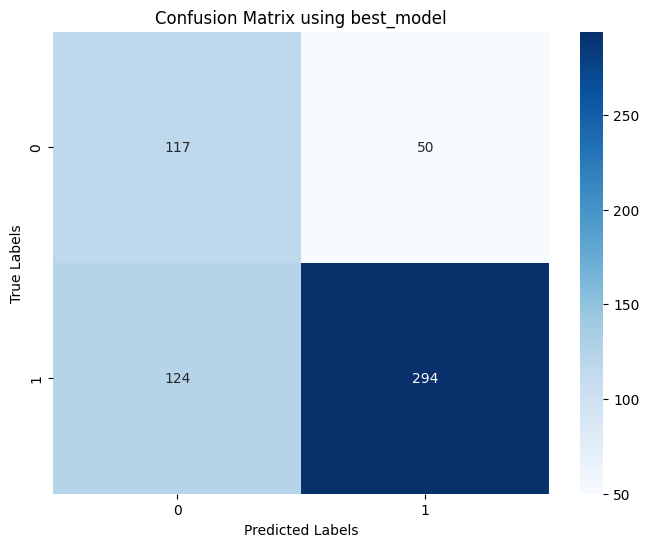

In [14]:
correct_predictions = (y_pred_baseline == y_test).sum()
print(f"Number of correct predictions: {correct_predictions} \n Percentage: {correct_predictions/y_test.shape[0]}")

cm = confusion_matrix(y_test, y_pred_baseline)

# Plotting using seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix using best_model")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


In [15]:
TN, FP, FN, TP = cm.ravel()

percentage_correct_0 = TN / (TN + FP) * 100
percentage_correct_1 = TP / (TP + FN) * 100

print(f"Percentage of correct predictions for label 0: {percentage_correct_0:.2f}%")
print(f"Percentage of correct predictions for label 1: {percentage_correct_1:.2f}%")


Percentage of correct predictions for label 0: 70.06%
Percentage of correct predictions for label 1: 70.33%


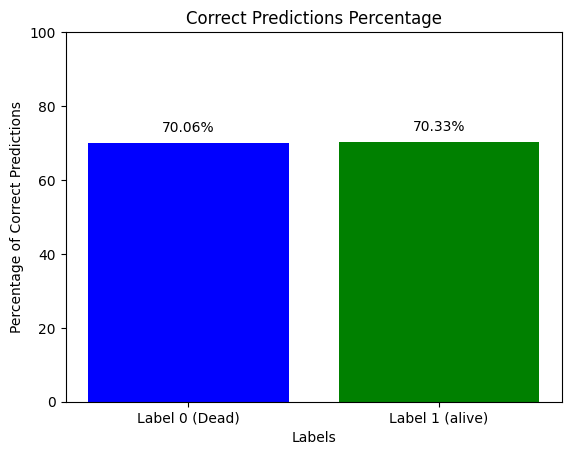

In [16]:
labels = ['Label 0 (Dead)', 'Label 1 (alive)']
percentages = [percentage_correct_0, percentage_correct_1]

plt.bar(labels, percentages, color=['blue', 'green'])
plt.xlabel('Labels')
plt.ylabel('Percentage of Correct Predictions')
plt.title('Correct Predictions Percentage')
plt.ylim(0, 100)  # Optional: set the y-axis to range from 0 to 100
for i, v in enumerate(percentages):
    plt.text(i, v + 3, f"{v:.2f}%", ha='center')  # Add text for each bar
plt.show()


In [17]:
print(classification_report(y_test, y_pred_baseline))


              precision    recall  f1-score   support

           0       0.49      0.70      0.57       167
           1       0.85      0.70      0.77       418

    accuracy                           0.70       585
   macro avg       0.67      0.70      0.67       585
weighted avg       0.75      0.70      0.72       585



# RandomSearchCV

In [18]:
# Hyperparameter space for Randomized Search
param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': uniform(0, 0.6)
}

# Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=300,  # Number of parameter settings sampled (adjust as needed)
    scoring=['accuracy', 'f1','recall', 'precision','roc_auc','f1_macro'],
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42
)


In [19]:

random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat_transformer',
                                                                               Pipeline(steps=[('OHE',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['origin']),
                                                                              ('num_transformer',
                                                                               Pipeline(steps=[('Standard_scaler',
                                                                                                StandardScaler())]),
                                                                               ['popularity']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['male',
                                                                                'isMarrie...
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x123916bc0>,
                                        'classifier__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x123942d70>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12369fc10>},
                   random_state=42, refit='f1_macro',
                   scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc',
                            'f1_macro'])

In [20]:
#random_search.cv_results_.keys()


In [21]:

# Results
print("Best parameters:", random_search.best_params_)
print("Best F1 macro score:", random_search.best_score_)

# You can also evaluate the model on the test set using the best estimator
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy:", test_score)
print(f"""mean_test_f1_macro: {random_search.cv_results_['mean_test_f1_macro'].mean()}
mean_test_accuracy: {random_search.cv_results_['mean_test_accuracy'].mean()}
mean_test_f1: {random_search.cv_results_['mean_test_f1'].mean()}
mean_test_recall: {random_search.cv_results_['mean_test_recall'].mean()}
mean_test_precision: {random_search.cv_results_['mean_test_precision'].mean()}
mean_test_roc_auc: {random_search.cv_results_['mean_test_roc_auc'].mean()}""")


Best parameters: {'classifier__gamma': 0.558010100886499, 'classifier__learning_rate': 0.02408322616990878, 'classifier__max_depth': 4, 'classifier__min_child_weight': 6, 'classifier__n_estimators': 200}
Best F1 macro score: 0.6640499910870877
Test set accuracy: 0.6957264957264957
mean_test_f1_macro: 0.649752202771288
mean_test_accuracy: 0.6901417438770381
mean_test_f1: 0.7681276527245342
mean_test_recall: 0.7188717948717948
mean_test_precision: 0.8257897610683905
mean_test_roc_auc: 0.7434767218536449


In [22]:
y_pred = best_model.predict(X_test)


In [23]:
print('Accuracy =', round(accuracy_score(y_test, y_pred), 2)) # Accuracy

print('Precision =', round(precision_score(y_test, y_pred), 2)) # Precision

print('Recall =', round(recall_score(y_test, y_pred), 2)) # Recall

print('F1 score =', round(f1_score(y_test, y_pred), 2))

print('F1 avg macro score =', round(f1_score(y_test, y_pred,average = 'macro'), 2))


Accuracy = 0.7
Precision = 0.86
Recall = 0.68
F1 score = 0.76
F1 avg macro score = 0.67


Number of correct predictions: 407 
 Percentage: 0.6957264957264957


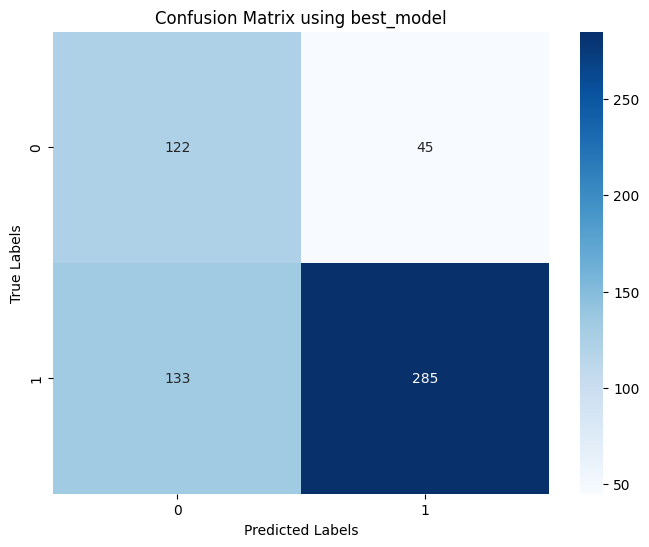

In [24]:

correct_predictions = (y_pred == y_test).sum()
print(f"Number of correct predictions: {correct_predictions} \n Percentage: {correct_predictions/y_test.shape[0]}")

cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix using best_model")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


In [25]:
TN, FP, FN, TP = cm.ravel()

percentage_correct_0 = TN / (TN + FP) * 100
percentage_correct_1 = TP / (TP + FN) * 100

print(f"Percentage of correct predictions for label 0: {percentage_correct_0:.2f}%")
print(f"Percentage of correct predictions for label 1: {percentage_correct_1:.2f}%")


Percentage of correct predictions for label 0: 73.05%
Percentage of correct predictions for label 1: 68.18%


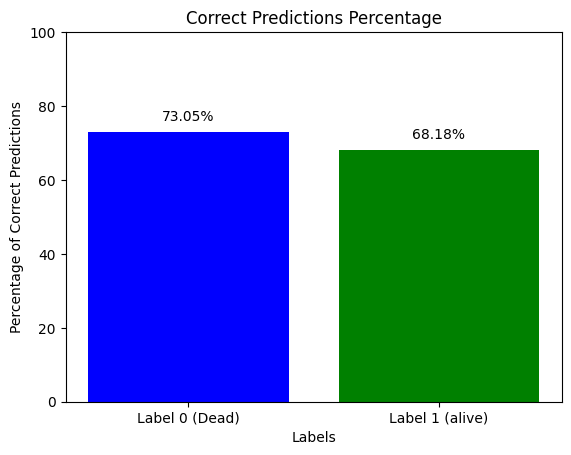

In [26]:
labels = ['Label 0 (Dead)', 'Label 1 (alive)']
percentages = [percentage_correct_0, percentage_correct_1]

plt.bar(labels, percentages, color=['blue', 'green'])
plt.xlabel('Labels')
plt.ylabel('Percentage of Correct Predictions')
plt.title('Correct Predictions Percentage')
plt.ylim(0, 100)  # Optional: set the y-axis to range from 0 to 100
for i, v in enumerate(percentages):
    plt.text(i, v + 3, f"{v:.2f}%", ha='center')  # Add text for each bar
plt.show()


In [27]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.73      0.58       167
           1       0.86      0.68      0.76       418

    accuracy                           0.70       585
   macro avg       0.67      0.71      0.67       585
weighted avg       0.75      0.70      0.71       585



# Bayesian Search

In [80]:
# Define Bayesian hyperparameter space
search_space = {
    'classifier__n_estimators': Integer(150, 350),
    'classifier__max_depth': Integer(20, 50),
    'classifier__learning_rate': Real(0.1, 0.5),
    'classifier__min_child_weight': Integer(5, 15),
    'classifier__gamma': Real(0.2, 0.7)
}

# BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    scoring='f1_macro',
    cv=5,
    n_iter=100,
    n_jobs=-1,
    random_state=42
)


In [81]:
bayes_search.fit(X_train, y_train)


/Users/Carmen/.pyenv/versions/3.10.6/envs/game-of-thrones-survival/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Carmen/.pyenv/versions/3.10.6/envs/game-of-thrones-survival/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Carmen/.pyenv/versions/3.10.6/envs/game-of-thrones-survival/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Carmen/.pyenv/versions/3.10.6/envs/game-of-thrones-survival/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat_transformer',
                                                                          Pipeline(steps=[('OHE',
                                                                                           OneHotEncoder(handle_unknown='ignore',
                                                                                                         sparse_output=False))]),
                                                                          ['origin']),
                                                                         ('num_transformer',
                                                                          Pipeline(steps=[('Standard_scaler',
                                                                                           StandardScaler())]),
                                                                          ['popularity']),
                                                                         ('passthrough',
                                                                          'passthrough',
                                                                          ['male',
                                                                           'isMarried',
                                                                           'i...
                             'classifier__learning_rate': Real(low=0.1, high=0.5, prior='uniform', transform='normalize'),
                             'classifier__max_depth': Integer(low=20, high=50, prior='uniform', transform='normalize'),
                             'classifier__min_child_weight': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=150, high=350, prior='uniform', transform='normalize')})

In [82]:

# Best parameters and best F1 macro score
print("Best parameters:", bayes_search.best_params_)
print("Best F1 macro score:", bayes_search.best_score_)


Best parameters: OrderedDict([('classifier__gamma', 0.7), ('classifier__learning_rate', 0.19685162680426677), ('classifier__max_depth', 20), ('classifier__min_child_weight', 6), ('classifier__n_estimators', 350)])
Best F1 macro score: 0.6654484582838436


In [83]:

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set f1 macro:", test_score)


Test set f1 macro: 0.6820512820512821


In [66]:
#bayes_search.cv_results_.keys()


In [85]:
print(f"mean_test_f1_macro of cv: {bayes_search.cv_results_['mean_test_score'].mean()}")


mean_test_f1_macro of cv: 0.6514898986811892


In [86]:
y_pred = best_model.predict(X_test)


In [87]:
print('Accuracy =', round(accuracy_score(y_test, y_pred), 2)) # Accuracy

print('Precision =', round(precision_score(y_test, y_pred), 2)) # Precision

print('Recall =', round(recall_score(y_test, y_pred), 2)) # Recall

print('F1 score =', round(f1_score(y_test, y_pred), 2))

print('F1 avg macro score =', round(f1_score(y_test, y_pred,average = 'macro'), 2))


Accuracy = 0.68
Precision = 0.84
Recall = 0.69
F1 score = 0.76
F1 avg macro score = 0.65


Number of correct predictions: 399 
 Percentage: 0.6820512820512821


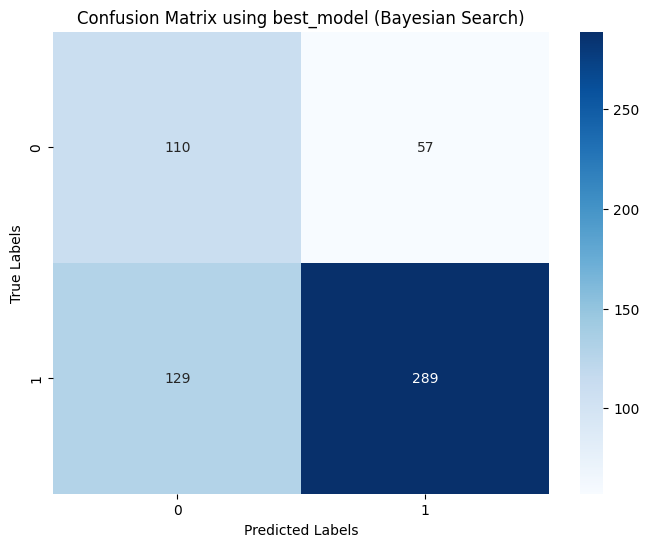

In [88]:

correct_predictions = (y_pred == y_test).sum()
print(f"Number of correct predictions: {correct_predictions} \n Percentage: {correct_predictions/y_test.shape[0]}")

cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix using best_model (Bayesian Search)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


In [89]:
TN, FP, FN, TP = cm.ravel()

percentage_correct_0 = TN / (TN + FP) * 100
percentage_correct_1 = TP / (TP + FN) * 100

print(f"Percentage of correct predictions for label 0: {percentage_correct_0:.2f}%")
print(f"Percentage of correct predictions for label 1: {percentage_correct_1:.2f}%")


Percentage of correct predictions for label 0: 65.87%
Percentage of correct predictions for label 1: 69.14%


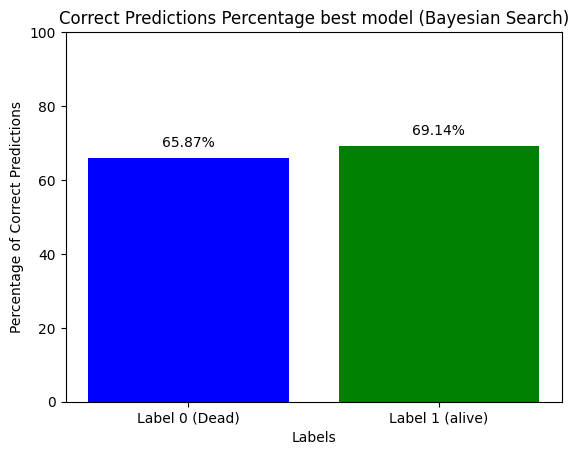

In [90]:
labels = ['Label 0 (Dead)', 'Label 1 (alive)']
percentages = [percentage_correct_0, percentage_correct_1]

plt.bar(labels, percentages, color=['blue', 'green'])
plt.xlabel('Labels')
plt.ylabel('Percentage of Correct Predictions')
plt.title('Correct Predictions Percentage best model (Bayesian Search)')
plt.ylim(0, 100)  # Optional: set the y-axis to range from 0 to 100
for i, v in enumerate(percentages):
    plt.text(i, v + 3, f"{v:.2f}%", ha='center')  # Add text for each bar
plt.show()


In [92]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.46      0.66      0.54       167
           1       0.84      0.69      0.76       418

    accuracy                           0.68       585
   macro avg       0.65      0.68      0.65       585
weighted avg       0.73      0.68      0.70       585

